In [1]:
!where python

/bin/bash: line 1: where: command not found


# Load libraries

In [2]:
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

import pandas as pd
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from glob import glob
import os
from copy import deepcopy

import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import optimizers
# from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import os
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from skimage.metrics import structural_similarity as ssim

import torch
from torch.utils.data import DataLoader, Dataset
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import v2
from torchvision import transforms
from sklearn.model_selection import train_test_split


# Define helper functions/classes

In [3]:
## convert RGB to the personal LAB (LAB2)
# the input R,G,B,  must be 1D from 0 to 255
# the outputs are 1D  L [0 1], a [-1 1] b [-1 1]
def RGB2LAB2(R0, G0, B0):

    R=R0/255
    G=G0/255
    B=B0/255

    # Y=0.3*R + 0.59*G + 0.11*B
    # X=0.45*R + 0.35*G + 0.2*B
    # Z=0.01*R + 0.09*G + 0.9*B

    Y=0.299*R + 0.587*G + 0.114*B
    X=0.449*R + 0.353*G + 0.198*B
    Z=0.012*R + 0.089*G + 0.899*B

    # X - Y = 0.150*R - 0.234*G + 0.084*B  = a0
    # Y - Z = 0.287*R + 0.498*G - 0.785*B  = b0

    L = Y
    a = (X - Y)/0.234
    b = (Y - Z)/0.785

    return L, a, b

## convert the personal LAB (LAB2)to the RGB
# the input L,a,b,  must be 1D L [0 1], a [-1 1] b [-1 1]
# the outputs are 1D  R g B [0 255]
def LAB22RGB(L, a, b):

    a11 = 0.299
    a12 = 0.587
    a13 = 0.114
    a21 = (0.15/0.234)
    a22 = (-0.234/0.234)
    a23 = (0.084/0.234)
    a31 = (0.287/0.785)
    a32 = (0.498/0.785)
    a33 = (-0.785/0.785)

    aa=np.array([[a11, a12, a13], [a21, a22, a23], [a31, a32, a33]])
    C0=np.zeros((L.shape[0],3))
    C0[:,0]=L[:,0]
    C0[:,1]=a[:,0]
    C0[:,2]=b[:,0]
    C = np.transpose(C0)
    # C = np.array([L, a, b])
    # print(C.shape)
    # print(L.shape)
    # print(a.shape)
    # print(b.shape)
    # print(aa.shape)

    X = np.linalg.inv(aa).dot(C)
    X1D=np.reshape(X,(X.shape[0]*X.shape[1],1))
    p0=np.where(X1D<0)
    X1D[p0[0]]=0
    p1=np.where(X1D>1)
    X1D[p1[0]]=1
    Xr=np.reshape(X1D,(X.shape[0],X.shape[1]))

    Rr = Xr[0][:]
    Gr = Xr[1][:]
    Br = Xr[2][:]

    R = np.uint(np.round(Rr*255))
    G = np.uint(np.round(Gr*255))
    B = np.uint(np.round(Br*255))
    # p0=np.where(L<0.02)
    # R[p0[0]]=0
    # G[p0[0]]=0
    # B[p0[0]]=0
    # p1=np.where(L>0.98)
    # R[p1[0]]=255
    # G[p1[0]]=255
    # B[p1[0]]=255
    return R, G, B

# def convert_to_feed_model_func(RGB_image):

#     sz0=RGB_image.shape[0]
#     sz1=RGB_image.shape[1]

#     train_imgs=np.zeros((sz0,sz1,2))
#     train_input=np.zeros((sz0,sz1,1))

#     ab=np.zeros((sz0,sz1,2))
#     R1 = np.reshape(RGB_image[:,:,0],(sz0*sz1,1))
#     G1 = np.reshape(RGB_image[:,:,1],(sz0*sz1,1))
#     B1 = np.reshape(RGB_image[:,:,2],(sz0*sz1,1))
#     L, A, B = RGB2LAB2(R1,G1,B1)
#     A = np.reshape(A,(sz0,sz1))
#     B = np.reshape(B,(sz0,sz1))
#     ab[:,:,0] = A
#     ab[:,:,1] = B
#     train_input[:,:,:] =  np.reshape(L,(1,sz0,sz1,1))
#     train_imgs[:,:,:] = np.reshape(ab,(1,sz0,sz1,2))

#     return (train_input, train_imgs)


In [4]:

####### Metrics #######


def psnr(img1, img2):
    mse = np.mean( (img1.astype("float") - img2.astype("float")) ** 2 )
    # print(mse)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

def mse(imageA, imageB, bands):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1] * bands)

	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err

def mae(imageA, imageB, bands):
 	# the 'Mean Squared Error' between the two images is the
 	# sum of the squared difference between the two images;
 	# NOTE: the two images must have the same dimension
 	err = np.sum(np.abs((imageA.astype("float") - imageB.astype("float"))))
 	err /= float(imageA.shape[0] * imageA.shape[1] * bands)
 	return err

def rmse(imageA, imageB, bands):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1] * bands)
	err = np.sqrt(err)
	return err

# Define transforms


In [5]:
class convert_RGB_to_feed_model(torch.nn.Module):
    def forward(self, img):
        img = np.asanyarray(img)
        sz0=img.shape[0]
        sz1=img.shape[1]

        train_imgs=np.zeros((sz0,sz1,2))
        train_input=np.zeros((sz0,sz1,1))

        ab=np.zeros((sz0,sz1,2))
        R1 = np.reshape(img[:,:,0],(sz0*sz1,1))
        G1 = np.reshape(img[:,:,1],(sz0*sz1,1))
        B1 = np.reshape(img[:,:,2],(sz0*sz1,1))
        L, A, B = RGB2LAB2(R1,G1,B1)
        A = np.reshape(A,(sz0,sz1))
        B = np.reshape(B,(sz0,sz1))
        ab[:,:,0] = A
        ab[:,:,1] = B
        train_input[:,:,:] =  np.reshape(L,(1,sz0,sz1,1))
        train_imgs[:,:,:] = np.reshape(ab,(1,sz0,sz1,2))
        return (train_input, train_imgs)

In [6]:
# NOTE: need to crate a transform class to revert from model to RGB, so the oposite from the class convert_RGB_to_feed_model
class convert_from_LAB_to_RGB(torch.nn.Module):
    def forward(self, img_raw):
        image, _ = img_raw
        print(image.shape)
        # sz0 = image.shape[0]
        # sz1 = image.shape[1]
        # sz2 = image.shape[2]
        # LAB_img = np.reshape(LAB_img,(sz0*sz1,bands))
        # Ar = LAB_img[:,0:1]
        # Br = LAB_img[:,1:2]

        # Rr, Gr, Br = LAB22RGB(L,Ar,Br)
        # Rr = np.reshape(Rr,(sz0,sz1))
        # Gr = np.reshape(Gr,(sz0,sz1))
        # Br = np.reshape(Br,(sz0,sz1))
        # predicted255=np.uint8(np.zeros((sz0,sz1,3)))
        # predicted255[:,:,0] = Rr
        # predicted255[:,:,1] = Gr
        # predicted255[:,:,2] = Br
        # return (predicted255)

In [7]:
img_new_dim = 512

train_transforms = transforms.Compose(
    [
        # transforms.Resize(size=(img_new_dim, img_new_dim)),
        convert_RGB_to_feed_model()
        # transforms.Lambda(convert_to_feed_model),
        # v2.RandomHorizontalFlip(p=1),
        # v2.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
    ]
)

# Download the raw data

The data was initially created using the scripts `retrieve_data.ipynb` and stored in a private server for later (re)use.

NOTE: the following are links stored in a private server, jet publically available

In [8]:
# raw_data_csv_file_link = "https://perritos.myasustor.com:3853/portal/apis/fileExplorer/download.cgi?act=download&link=EKxhA76k9&link_session_id=cDXOk9eeE9Es2a1JU1IOvA00&total=1&browser=firefox&mod_cntype=0&path=%2FRuben%2Fdatasets%2Ffetched_raw_imgs_via_api&file=metadata.csv"
raw_data_csv_file_link = "https://perritos.myasustor.com:1985/metadata.csv"
# only working locally
# raw_data_csv_file_link =
# "/Volumes/Ruben/datasets/fetched_raw_imgs_via_api/metadata.csv"

metadata_raw_df = pd.read_csv(raw_data_csv_file_link, index_col=0)
metadata_raw_df

,img_id,img_name,latitude,longitude,zoom_level,class,link
0,0,3857_17_68545_45993,47.201780,8.264822,17,61,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....
1,1,3857_16_34290_23041,47.032835,8.360899,16,61,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....
2,2,3857_16_34497_22906,47.536282,9.500052,16,61,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....
3,3,3857_17_67996_46176,46.860006,6.759327,17,61,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....
4,4,3857_17_68797_46090,47.021068,8.959244,17,61,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....
...,...,...,...,...,...,...,...
3595,3595,3857_17_68680_46248,46.723525,8.635565,17,66,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....
3596,3596,3857_16_34412_23109,46.778972,9.030993,16,66,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....
3597,3597,3857_17_68885_46306,46.613634,9.199782,17,66,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....
3598,3598,3857_16_34489_23157,46.598598,9.455155,16,66,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....


In [9]:
metadata_raw_df["class"].iloc[0]

61

In [10]:
metadata_raw_df.shape

(3600, 7)

# Create Train, Valid and Test datasets

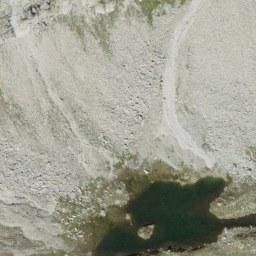

In [11]:
# This is an example how to retrieve a sample image
url = "https://perritos.myasustor.com:1985/data/img_id_10.jpg"
# url = "https://192.168.1.144:1985/data/img_id_0.jpg"
response = requests.get(url)
img_test = Image.open(BytesIO(response.content))
img_test

In [12]:
transformed_img = train_transforms(img_test)
transformed_img

(array([[[0.64623137],
         [0.72074118],
         [0.74427059],
         ...,
         [0.68269804],
         [0.71407059],
         [0.77681569]],
 
        [[0.61093725],
         [0.70897647],
         [0.76387843],
         ...,
         [0.69838431],
         [0.70622745],
         [0.73367843]],
 
        [[0.68293333],
         [0.72607059],
         [0.70646275],
         ...,
         [0.72191373],
         [0.71407059],
         [0.69054118]],
 
        ...,
 
        [[0.56183922],
         [0.54105882],
         [0.5265451 ],
         ...,
         [0.56870196],
         [0.59615294],
         [0.53732941]],
 
        [[0.53628627],
         [0.52172941],
         [0.51275686],
         ...,
         [0.49508627],
         [0.49900784],
         [0.48332157]],
 
        [[0.52844314],
         [0.51275686],
         [0.51667843],
         ...,
         [0.53038039],
         [0.53038039],
         [0.54606667]]]),
 array([[[-0.01377577,  0.0299388 ],
         [-0.01377

We use the column `image_id` from the metadata as index of the images and then we perform standard shufling and splitting.

The final ratio for the train, validation and test dastasets are: 75, 15 and 10 % respectively

In [13]:
dataX, dataY = metadata_raw_df["img_id"].to_list(), metadata_raw_df["class"] .to_list()

rand_state = 9898
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10



# train is now 75% of the entire data set
x_train, x_test, y_train, y_test = train_test_split(dataX, dataY, test_size=1 - train_ratio, stratify = dataY, random_state=rand_state)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), stratify=y_test, random_state=rand_state)

print(f"the size fo the train dataset is: {len(x_train)}.\nthe size fo the validation dataset is: {len(x_val)}.\nthe size fo the test dataset is: {len(x_test)}.")

the size fo the train dataset is: 2700.
the size fo the validation dataset is: 540.
the size fo the test dataset is: 360.


# Create a Dataset class

In [14]:
# the idea was borrowed from here: https://towardsdatascience.com/custom-dataset-in-pytorch-part-1-images-2df3152895

class Swisstopodataset(Dataset):
    def __init__(self, img_indx, metadata_file, transform = False):
        self.img_indx = img_indx
        self.transform = transform
        self.metadata_file = metadata_file

    def __len__(self):
        return len(self.img_indx)

    def __getitem__(self, idx):
        # img_filepath  = self.img_indx[idx]
        response = requests.get(f"https://perritos.myasustor.com:1985/data/img_id_{self.img_indx[idx]}.jpg")
        image = Image.open(BytesIO(response.content))
        # image = cv2.imread(img_filepath)
        # image = Image.fromarray(image)

        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # define here a label if existing
        label = self.metadata_file["class"].iloc[idx]

        if self.transform is not None:
            image = self.transform(image)

        return image, label


In [15]:
train_dataset = Swisstopodataset(x_train, metadata_file=metadata_raw_df, transform=train_transforms)
valid_dataset= Swisstopodataset(x_val, metadata_file=metadata_raw_df, transform=train_transforms)
test_dataset= Swisstopodataset(x_test, metadata_file=metadata_raw_df, transform=train_transforms)
example_indx = 49

print(f"The shape of tensor for {example_indx +1 }th image in the train dataset of: \nchannel L is:{train_dataset[example_indx][0][0].shape}\nchannel AB is:{train_dataset[example_indx][0][1].shape}\nlabel: {train_dataset[example_indx][1]}")
print(f"\n\nThe shape of tensor for {example_indx +1 }th image in the validate dataset of: \nchannel L is:{train_dataset[example_indx][0][0].shape}\nchannel AB is:{train_dataset[example_indx][0][1].shape}\nlabel: {train_dataset[example_indx][1]}")
# print(f"The shape of tensor for 50th image in train dataset of channel L is :{train_dataset[49][0].shape}\nand of channel AB is :{train_dataset[49][1].shape}")


The shape of tensor for 50th image in the train dataset of: 
channel L is:(256, 256, 1)
channel AB is:(256, 256, 2)
label: 61


The shape of tensor for 50th image in the validate dataset of: 
channel L is:(256, 256, 1)
channel AB is:(256, 256, 2)
label: 61


In [16]:
valid_dataset[1]

((array([[[0.53572549],
          [0.622     ],
          [0.59847059],
          ...,
          [0.56054902],
          [0.58407843],
          [0.59192157]],
  
         [[0.56709804],
          [0.64552941],
          [0.61807843],
          ...,
          [0.59584314],
          [0.61152941],
          [0.63113725]],
  
         [[0.4847451 ],
          [0.48866667],
          [0.47298039],
          ...,
          [0.6224    ],
          [0.62632157],
          [0.65769412]],
  
         ...,
  
         [[0.55281176],
          [0.47045882],
          [0.47830196],
          ...,
          [0.5692    ],
          [0.61048235],
          [0.64577647]],
  
         [[0.50575294],
          [0.49006667],
          [0.55281176],
          ...,
          [0.52214118],
          [0.51244314],
          [0.5673451 ]],
  
         [[0.49398824],
          [0.53320392],
          [0.50575294],
          ...,
          [0.66723922],
          [0.59871765],
          [0.60263922]]]),
  arra

# Visualize the datasets (images)

In [17]:
def visualize_dataset(dataset, samples = 10, cols = 5, random_img = False):
    dataset = deepcopy(dataset)
    # revert transforms if exixting
    # dataset.transform = transforms.Compose([t for t in dataset.transform if not isinstance(t, convert_RGB_to_feed_model)])
    dataset.transform = transforms.Compose([t for t in test_dataset.transform.transforms if not t.__class__.__name__ == "convert_RGB_to_feed_model"])
    # if "convert_RGB_to_feed_model" in test_dataset.transform.transforms:
    #     dataset.transform = transforms.Compose()

    rows = samples // cols

    figure, ax = plt.subplots(nrows= rows, ncols = cols, figsize = (12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1, len(dataset))
        image, label = dataset[idx][0], dataset[idx][1]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(f"Img label: {label}")
    plt.tight_layout(pad=1)
    plt.show()

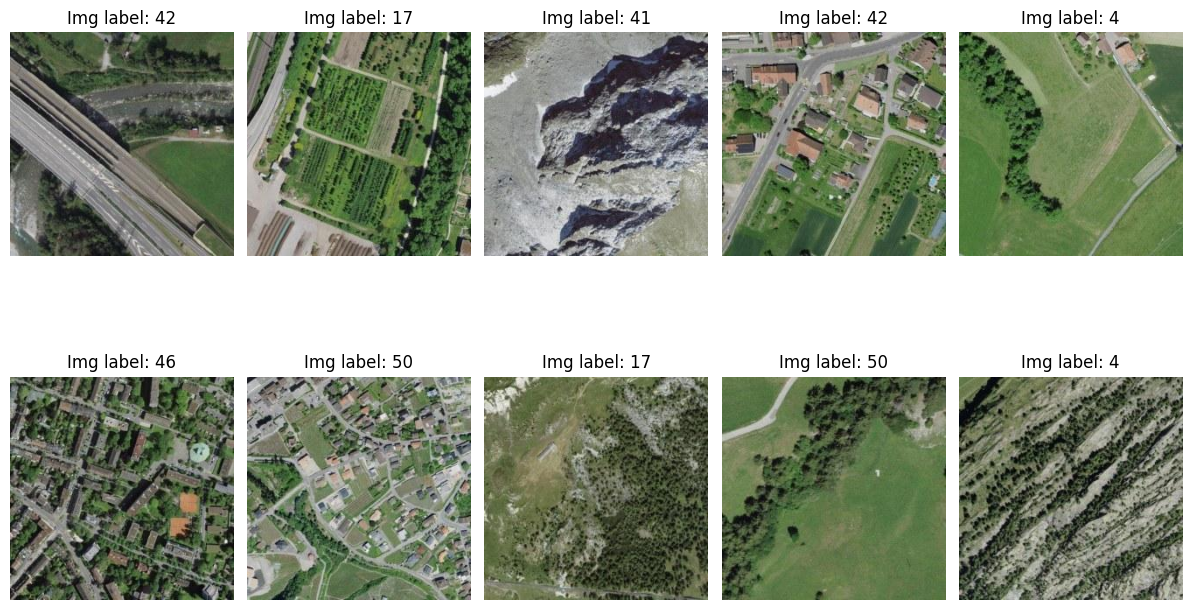

In [18]:
visualize_dataset(test_dataset, random_img= True)

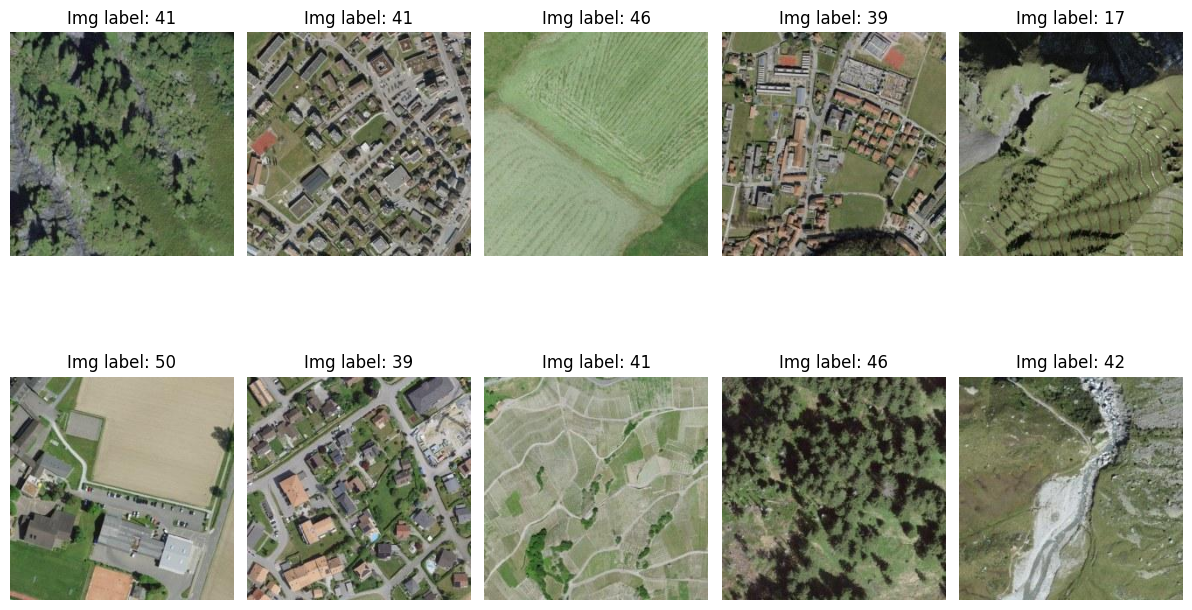

In [19]:
visualize_dataset(valid_dataset, random_img= True)

## Load data for Tensorflow

In [20]:
class Swisstopodataset(Dataset):
    def __init__(self, img_indx, metadata_file, transform=False):
        self.img_indx = img_indx
        self.transform = transform
        self.metadata_file = metadata_file

    def __len__(self):
        return len(self.img_indx)

    def __getitem__(self, idx):
        response = requests.get(f"https://perritos.myasustor.com:1985/data/img_id_{self.img_indx[idx]}.jpg")
        image = Image.open(BytesIO(response.content))

        if self.transform is not None:
            image = self.transform(image)

        return image


In [21]:
train_dataset = Swisstopodataset(x_train, metadata_file=metadata_raw_df, transform=train_transforms)
valid_dataset = Swisstopodataset(x_val, metadata_file=metadata_raw_df, transform=train_transforms)
test_dataset = Swisstopodataset(x_test, metadata_file=metadata_raw_df, transform=train_transforms)

print(train_dataset[0][0].shape)
print(train_dataset[0][1].shape)



(256, 256, 1)
(256, 256, 2)


In [22]:
train_samples = len(train_dataset)
valid_samples = len(valid_dataset)
test_samples = len(test_dataset)

In [1]:
# Print the number of samples
print("Number of samples in the training dataset:", train_samples)
print("Number of samples in the validation dataset:", valid_samples)
print("Number of samples in the test dataset:", test_samples)

NameError: name 'train_samples' is not defined

In [24]:
# Create TensorFlow datasets
def create_tf_dataset(dataset, desc):
    L_channel_data = []
    AB_channel_data = []
    total_samples = len(dataset)
    with tqdm(total=total_samples, desc=desc) as pbar:
        for sample in dataset:
            L_channel_data.append(sample[0])
            AB_channel_data.append(sample[1])
            pbar.update(1)
    return tf.data.Dataset.from_tensor_slices((L_channel_data, AB_channel_data))


In [25]:
train_data = create_tf_dataset(train_dataset, desc="Training data")
valid_data = create_tf_dataset(valid_dataset, desc="Validation data")
test_data = create_tf_dataset(test_dataset, desc="Test data")

Test data: 100%|██████████| 360/360 [05:54<00:00,  1.02it/s]


In [26]:
# Shuffle and batch the datasets
batch_size = 16
train_data = train_data.shuffle(buffer_size=len(train_dataset)).batch(batch_size)
valid_data = valid_data.shuffle(buffer_size=len(valid_dataset)).batch(batch_size)
test_data = test_data.batch(batch_size)

In [27]:
# Example usage to verify shapes:
for L_channel, AB_channels in train_data.take(1):
    print("Shape of L channel in train data batch:", L_channel.shape)
    print("Shape of AB channels in train data batch:", AB_channels.shape)

for L_channel, AB_channels in valid_data.take(1):
    print("Shape of L channel in validation data batch:", L_channel.shape)
    print("Shape of AB channels in validation data batch:", AB_channels.shape)

for L_channel, AB_channels in test_data.take(1):
    print("Shape of L channel in test data batch:", L_channel.shape)
    print("Shape of AB channels in test data batch:", AB_channels.shape)


Shape of L channel in train data batch: (64, 256, 256, 1)
Shape of AB channels in train data batch: (64, 256, 256, 2)
Shape of L channel in validation data batch: (64, 256, 256, 1)
Shape of AB channels in validation data batch: (64, 256, 256, 2)
Shape of L channel in test data batch: (64, 256, 256, 1)
Shape of AB channels in test data batch: (64, 256, 256, 2)


# Evaluation Metrics

In [28]:
def mae(imageA, imageB, bands):
 	# the 'Mean Squared Error' between the two images is the
 	# sum of the squared difference between the two images;
 	# NOTE: the two images must have the same dimension
 	err = np.sum(np.abs(imageA.astype("float") - imageB.astype("float")))
 	err /= float(imageA.shape[0] * imageA.shape[1] * bands)

In [29]:
def psnr(img1, img2):
    mse = np.mean( (img1.astype("float") - img2.astype("float")) ** 2 )
    # print(mse)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [30]:
def mse(imageA, imageB, nband):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1] * nband)

	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err

In [31]:
def rmse(imageA, imageB, nband):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1] * nband)
	err = np.sqrt(err)
	return err

# Retrain the model

In [32]:
!pip install gdown
!gdown --id 19DaA9f1HIOW9PmUz11xKw65fCo3X7-Fw --output Hyper_U_Net.h5

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=19DaA9f1HIOW9PmUz11xKw65fCo3X7-Fw
From (redirected): https://drive.google.com/uc?id=19DaA9f1HIOW9PmUz11xKw65fCo3X7-Fw&confirm=t&uuid=be11e28f-1925-403c-91eb-0bcb54b6d64e
To: /content/Hyper_U_Net.h5
100% 500M/500M [00:24<00:00, 20.2MB/s]


In [36]:
# Define the file path of the downloaded model
model_file_path = '/content/Hyper_U_Net.h5'

# Load the saved model
loaded_model = tf.keras.models.load_model(model_file_path)

# Freeze all layers except the last one
for layer in loaded_model.layers[:-1]:
    layer.trainable = False

# Function to count the number of parameters
def count_params(model, only_trainable=False):
    if only_trainable:
        return np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    else:
        return np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights + model.non_trainable_weights])

# Get the number of trainable and non-trainable parameters
trainable_params = count_params(loaded_model, only_trainable=True)
total_params = count_params(loaded_model)

print(f"Trainable parameters: {trainable_params}")
print(f"Total parameters: {total_params}")

# Display model summary
loaded_model.summary()

Trainable parameters: 1154
Total parameters: 41615234
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 1)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 64)       640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, None, None, 64)       36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, None, None, 64)       0         ['conv2d_1[0][0]']            
 D)                                     

In [37]:
# Compile the model
loaded_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])


In [ ]:
epochs = 1
history = loaded_model.fit(train_data, validation_data=valid_data, epochs=epochs)

test_loss = loaded_model.evaluate(test_data)
print(f'Test Loss: {test_loss}')

## Evaluation

In [ ]:
MSE_list = []
MAE_list = []
MSEr_list = []
MSEg_list = []
MSEb_list = []
RMSE_list = []
PSNR_list = []
SSIM_list = []
deltaE_list = []

for j1 in range(N):
    print('final2 image = ',j1)

    # ima0 = img_to_array(load_img(filesTs_list[j1][:]))
    # if(ima0.shape[0]%64>0):
    #     d00 = int(ima0.shape[0]/64)
    #     d0 = (d00+1)*64
    # else:
    #     d0=ima0.shape[0]
    # if(ima0.shape[1]%64>0):
    #     d11 = int(ima0.shape[1]/64)
    #     d1 = (d11+1)*64
    # else:
    #     d1=ima0.shape[1]

    # ima = np.zeros((d0,d1,ima0.shape[2]))
    # ima[0:ima0.shape[0],0:ima0.shape[1],:] = ima0
    # else:
                #     ima = ima0


    ima = cv2.imread(filesTs_list[j1][:])
    ima0 = ima


    sz0 = ima.shape[0]
    sz1 = ima.shape[1]
    sz2 = bands #ima.shape[2]

    sz0=ima0.shape[0]
    sz1=ima0.shape[1]
    ab=np.zeros((sz0,sz1,2))
    R1 = np.reshape(ima0[:,:,0],(sz0*sz1,1))
    G1 = np.reshape(ima0[:,:,1],(sz0*sz1,1))
    B1 = np.reshape(ima0[:,:,2],(sz0*sz1,1))
    L, A, B = RGB2LAB2(R1,G1,B1)
    A = np.reshape(A,(sz0,sz1))
    B = np.reshape(B,(sz0,sz1))
    ab[:,:,0] = A
    ab[:,:,1] = B
    ima_gray =  np.reshape(L,(1,sz0,sz1,1))

    predicted = model1.predict(ima_gray,verbose=0)

    predicted = np.reshape(predicted,(sz0*sz1,bands))
    Ar = predicted[:,0:1]
    Br = predicted[:,1:2]

    Rr, Gr, Br = LAB22RGB(L,Ar,Br)
    Rr = np.reshape(Rr,(sz0,sz1))
    Gr = np.reshape(Gr,(sz0,sz1))
    Br = np.reshape(Br,(sz0,sz1))
    predicted255=np.uint8(np.zeros((sz0,sz1,3)))
    predicted255[:,:,0] = Rr
    predicted255[:,:,1] = Gr
    predicted255[:,:,2] = Br

    cv2.imwrite(cwd +'/02_data/pred_swissimage/'+files_name1[j1][:]+'.tif',predicted255)




    MSE = mse(ima0,predicted255,3)
    MSEr = mse(ima0[:,:,0],predicted255[:,:,0],1)
    MSEg = mse(ima0[:,:,1],predicted255[:,:,1],1)
    MSEb = mse(ima0[:,:,2],predicted255[:,:,2],1)
    RMSE = rmse(ima0,predicted255,3) #
    # MAE = mae(ima0,predicted255,3)
    err = np.sum(np.abs(ima0.astype("float") - predicted255.astype("float")))
    MAE = err/float(ima0.shape[0] * predicted255.shape[1] * 3)
    # print('MAE = ',MAE)
        # PSNR = tf.image.psnr(, predicted255 , max_val=255)
    PSNR=psnr(ima0,predicted255)
    SSIM = ssim(ima0,predicted255, channel_axis=2) # PAST ssim(ima0,predicted255, multichannel=True) # deprecated

    ima0 = np.float32(ima0)
    predicted255 = np.float32(predicted255)
    ima0 *= 1./255
    predicted255 *= 1./255
    Lab1 = cv2.cvtColor(ima0, cv2.COLOR_BGR2Lab)
    Lab2 = cv2.cvtColor(predicted255, cv2.COLOR_BGR2Lab)
    L1, a1, b1 = cv2.split(Lab1)
    L2, a2, b2 = cv2.split(Lab2)
    #print(L2)

    Kl=1
    KC=1
    KH=1

    delta=skimage.color.deltaE_ciede2000(L1,L2, Kl, KC, KH)
    #print(len(delta))

    deltaE=np.mean(delta)
    # print("deltaE", m)

    # deltaE=delta_e_cie2000(ima0, predicted255, Kl=1, Kc=1, Kh=1)

    MSE_list.append(MSE)
    MSEr_list.append(MSEr)
    MSEg_list.append(MSEg)
    MSEb_list.append(MSEb)
    RMSE_list.append(RMSE)
    MAE_list.append(MAE)
    deltaE_list.append(deltaE)
        # MSE2_list.append(MSE2)
        # MAE2_list.append(MAE2)
    SSIM_list.append(SSIM)
    PSNR_list.append(PSNR)

    # id_Ac = id_Ac + 1

MSE_mean = np.mean(MSE_list)
MAE_mean = np.mean(MAE_list)
PSNR_mean = np.mean(PSNR_list)
SSIM_mean = np.mean(SSIM_list)
MSEr_mean = np.mean(MSEr_list)
MSEg_mean = np.mean(MSEg_list)
MSEb_mean = np.mean(MSEb_list)
RMSE_mean = np.mean(RMSE_list)
deltaE_mean = np.mean(deltaE_list)

# print('MSE_mean=',MSE_mean)
# print('RMSE_mean=',RMSE_mean)
print('deltaE_mean=',deltaE_mean)
print('MAE_mean=',MAE_mean)
print('PSNR_mean=',PSNR_mean)
print('SSIM_mean=',SSIM_mean)
